# **Changes**
- Add learning rate of 0.002 to Adam optimizer in each of the models
- Change batch sizing to 32 in model fit
- Increase epochs to 200 in model fitting
- Increase hidden layer nodes to 15 in each model
  - *I would like to increase the hidden layer more, but it would take a really long time for my computer to run it*

The original loss was roughly 0.0681 at the lowest end on the piece model.  Adding a learning rate to the Adam optimizer decreased the loss of all models slightly.  Adding more nodes in the hidden layer dropped that piece loss to 0.0631.  The low end of the alpha model was 0.1141.  Adding more nodes to that model dropped it to 0.1050. The low end of the number model was 0.1094.  Adding more nodes to that model dropped it to 0.1062.

When evaluating the chess game, the machine performs better than the original, but not by a lot.  I think more nodes would help that situation to a certain extent.  There are still poor moves being made in the game, but the opponent punishes those mistakes much quicker.


# **Libraries Loading**

In [5]:
import chess
import os 
import pandas as pd 
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# **Dataset Reading**

1. Uploading the chess_game.csv if its not exist on drive.
2. Number of chess games from dataset used for training algorithm.

In [6]:
indice = 500 # number of chess games used in training out of available in dataset.
os.chdir('/content/sample_data')
df = pd.read_csv('chess_game-1.csv')
data = df['moves'].tolist()[:indice]

# **Dataset Preprocessing**

1. Extracting single game all moves keys from dataset.
2. Dividing single game moves into steps
3. Using chess library extracting board state from move.
4. Defining training matrix from individual moves.
5. Translating matrix stages positions to arrays for model training
6. Making labels from arrays for training  

In [7]:
split_data = []
for point in data[:indice]:
    point = point.split()
    split_data.append(point)

In [8]:
data = []
for game in split_data:
    board = chess.Board()
    for move in game:
        board_ready = board.copy()
        data.append(board.copy())
        board.push_san(move)

In [9]:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
alpha_dict = {
    'a' : [0,0,0,0,0,0,0],
    'b' : [1,0,0,0,0,0,0],
    'c' : [0,1,0,0,0,0,0],
    'd' : [0,0,1,0,0,0,0],
    'e' : [0,0,0,1,0,0,0],
    'f' : [0,0,0,0,1,0,0],
    'g' : [0,0,0,0,0,1,0],
    'h' : [0,0,0,0,0,0,1],
}
number_dict = {
    1 : [0,0,0,0,0,0,0],
    2 : [1,0,0,0,0,0,0],
    3 : [0,1,0,0,0,0,0],
    4 : [0,0,1,0,0,0,0],
    5 : [0,0,0,1,0,0,0],
    6 : [0,0,0,0,1,0,0],
    7 : [0,0,0,0,0,1,0],
    8 : [0,0,0,0,0,0,1],
}

In [10]:
def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo

def translate(matrix,chess_dict):

    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

def flatten(l): 
    return [item for sublist in l for item in sublist]

trans_data = []
for board in data:
    matrix = make_matrix(board)
    trans = translate(matrix,chess_dict)
    trans_data.append(trans)

pieces = []
alphas = []
numbers = []

true_data = flatten(split_data)

for i in range(len(true_data)):
    try:
        term = flatten(split_data)[i]
        original = term[:]
        term = term.replace('x','')
        term = term.replace('#','')
        term = term.replace('+','')
        if len(term) == 2:
            piece = 'p' 
        else:
            piece = term[0]
        alpha = term[-2]
        number = term[-1]
        pieces.append(chess_dict[piece])
        alphas.append(alpha_dict[alpha])
        numbers.append(number_dict[int(number)])
    except:
        pass
print("Transformed data")

Transformed data


# **Model Building**

Defining 3 models for prediction of pieces, Alpha and Numbers predictions.



In [11]:
# 0.0681 is lowest, can add learning rate to Adam
def createModelPiece():
    board_inputs = keras.Input(shape=(8, 8, 12))
    conv1 = layers.Conv2D(15, 3, activation='relu')
    conv2 = layers.Conv2D(15, 3, activation='relu')
    pooling1 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    pooling2 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    flatten = keras.layers.Flatten(data_format=None)
    x = conv1(board_inputs)
    x = pooling1(x)
    x = conv2(x)
    x = flatten(x)
    piece_output = layers.Dense(12, name='piece')(x)
    model_pieces = keras.Model(
        inputs=board_inputs, outputs=piece_output, name="chess_ai_v3")
    
    model_pieces.compile(
        loss=keras.losses.mse,
        optimizer=keras.optimizers.Adam(lr = 0.002),
        metrics=None,
    )
    
    return model_pieces
def createModelAlpha():
    board_inputs = keras.Input(shape=(8, 8, 12))
    conv1 = layers.Conv2D(15, 3, activation='relu')
    conv2 = layers.Conv2D(15, 3, activation='relu')
    pooling1 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    pooling2 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    flatten = keras.layers.Flatten(data_format=None)
    x = conv1(board_inputs)
    x = pooling1(x)
    x = conv2(x)
    x = flatten(x)
    alpha_output = layers.Dense(7, name='alpha')(x)
    model_alpha = keras.Model(
        inputs=board_inputs, outputs=alpha_output, name="chess_ai_v3")
    
    model_alpha.compile(
        loss=keras.losses.mse,
        # add lr for adam in keras docs
        optimizer=keras.optimizers.Adam(lr = 0.002),
        metrics=None,)
    
    return model_alpha


def createModelNumber():
    board_inputs = keras.Input(shape=(8, 8, 12))
    conv1 = layers.Conv2D(15, 3, activation='relu')
    conv2 = layers.Conv2D(15, 3, activation='relu')
    pooling1 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    pooling2 = layers.MaxPooling2D(pool_size=(
        2, 2), strides=None, padding="valid", data_format=None,)
    flatten = keras.layers.Flatten(data_format=None)
    x = conv1(board_inputs)
    x = pooling1(x)
    x = conv2(x)
    x = flatten(x)
    numbers_output = layers.Dense(7, name='number')(x)
    model_number = keras.Model(
        inputs=board_inputs, outputs=numbers_output, name="chess_ai_v3")
    model_number.compile(
        loss=keras.losses.mse,
        optimizer=keras.optimizers.Adam(lr = 0.002),
        metrics=None,
    )
    
    return model_number

# **Models Training**

1. Using earling stop to stop the training when model not coverging
2. Train all the models if save model not found
3. Save the model


In [12]:
earlystop = keras.callbacks.EarlyStopping(
        monitor='loss', min_delta=0, patience=250, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

In [13]:
print("Loading model_pieces")
if os.path.exists("model_pieces\\"):
    model_pieces = keras.models.load_model("model_pieces")
else:
    model_pieces = createModelPiece()
print("Loaded model_pieces")
model_pieces.fit(trans_data[:len(pieces)],
                  # change batch(training data) to 32, increase epochs
                  pieces[:len(pieces)], batch_size=32, epochs=200, verbose=2, callbacks=[earlystop])
model_pieces.save("model_pieces")
print("Saved model_pieces")

Loading model_pieces


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Loaded model_pieces
Epoch 1/200
853/853 - 32s - loss: 0.0698 - 32s/epoch - 38ms/step
Epoch 2/200
853/853 - 3s - loss: 0.0687 - 3s/epoch - 3ms/step
Epoch 3/200
853/853 - 3s - loss: 0.0684 - 3s/epoch - 3ms/step
Epoch 4/200
853/853 - 3s - loss: 0.0680 - 3s/epoch - 3ms/step
Epoch 5/200
853/853 - 3s - loss: 0.0676 - 3s/epoch - 3ms/step
Epoch 6/200
853/853 - 3s - loss: 0.0672 - 3s/epoch - 3ms/step
Epoch 7/200
853/853 - 3s - loss: 0.0670 - 3s/epoch - 3ms/step
Epoch 8/200
853/853 - 3s - loss: 0.0668 - 3s/epoch - 3ms/step
Epoch 9/200
853/853 - 3s - loss: 0.0666 - 3s/epoch - 3ms/step
Epoch 10/200
853/853 - 3s - loss: 0.0664 - 3s/epoch - 3ms/step
Epoch 11/200
853/853 - 3s - loss: 0.0662 - 3s/epoch - 3ms/step
Epoch 12/200
853/853 - 3s - loss: 0.0660 - 3s/epoch - 3ms/step
Epoch 13/200
853/853 - 3s - loss: 0.0659 - 3s/epoch - 3ms/step
Epoch 14/200
853/853 - 3s - loss: 0.0657 - 3s/epoch - 3ms/step
Epoch 15/200
853/853 - 3s - loss: 0.0656 - 3s/epoch - 3ms/step
Epoch 16/200
853/853 - 3s - loss: 0.0655 

In [14]:
print("Loading model_alpha (columns)")
if os.path.exists("model_alpha\\"):
    model_alpha = keras.models.load_model("model_alpha")
else:
    model_alpha = createModelAlpha()
print("Loaded model_alpha (columns)")

# change batch to 32, increase epochs
model_alpha.fit(trans_data[:len(alphas)], alphas[:len(alphas)], batch_size=32, epochs=200,verbose=2, callbacks=[earlystop])
model_alpha.save("model_alpha")
print("Saved model_alpha (columns)")

Loading model_alpha (columns)
Loaded model_alpha (columns)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
853/853 - 3s - loss: 0.1150 - 3s/epoch - 4ms/step
Epoch 2/200
853/853 - 3s - loss: 0.1137 - 3s/epoch - 3ms/step
Epoch 3/200
853/853 - 3s - loss: 0.1135 - 3s/epoch - 3ms/step
Epoch 4/200
853/853 - 3s - loss: 0.1132 - 3s/epoch - 3ms/step
Epoch 5/200
853/853 - 3s - loss: 0.1130 - 3s/epoch - 3ms/step
Epoch 6/200
853/853 - 3s - loss: 0.1128 - 3s/epoch - 3ms/step
Epoch 7/200
853/853 - 3s - loss: 0.1125 - 3s/epoch - 3ms/step
Epoch 8/200
853/853 - 3s - loss: 0.1122 - 3s/epoch - 3ms/step
Epoch 9/200
853/853 - 3s - loss: 0.1120 - 3s/epoch - 3ms/step
Epoch 10/200
853/853 - 3s - loss: 0.1117 - 3s/epoch - 3ms/step
Epoch 11/200
853/853 - 3s - loss: 0.1115 - 3s/epoch - 3ms/step
Epoch 12/200
853/853 - 3s - loss: 0.1113 - 3s/epoch - 3ms/step
Epoch 13/200
853/853 - 3s - loss: 0.1110 - 3s/epoch - 3ms/step
Epoch 14/200
853/853 - 3s - loss: 0.1109 - 3s/epoch - 3ms/step
Epoch 15/200
853/853 - 3s - loss: 0.1107 - 3s/epoch - 3ms/step
Epoch 16/200
853/853 - 3s - loss: 0.1105 - 3s/epoch - 4ms/step
E

In [15]:
print("Loading model_number (rows)")
if os.path.exists("model_number\\"):
    model_number = keras.models.load_model("model_number")
else:
    model_number = createModelNumber()
print("Loaded model_number (rows)")

model_number.fit(trans_data[:len(numbers)], numbers[:len(numbers)], batch_size=32, epochs=200,verbose=2, callbacks=[earlystop])
model_number.save("model_number")
print("Saved model_number (rows)")

Loading model_number (rows)
Loaded model_number (rows)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
853/853 - 3s - loss: 0.1147 - 3s/epoch - 4ms/step
Epoch 2/200
853/853 - 3s - loss: 0.1135 - 3s/epoch - 3ms/step
Epoch 3/200
853/853 - 3s - loss: 0.1133 - 3s/epoch - 3ms/step
Epoch 4/200
853/853 - 3s - loss: 0.1131 - 3s/epoch - 3ms/step
Epoch 5/200
853/853 - 3s - loss: 0.1129 - 3s/epoch - 4ms/step
Epoch 6/200
853/853 - 3s - loss: 0.1127 - 3s/epoch - 4ms/step
Epoch 7/200
853/853 - 3s - loss: 0.1125 - 3s/epoch - 3ms/step
Epoch 8/200
853/853 - 3s - loss: 0.1123 - 3s/epoch - 4ms/step
Epoch 9/200
853/853 - 3s - loss: 0.1121 - 3s/epoch - 4ms/step
Epoch 10/200
853/853 - 3s - loss: 0.1120 - 3s/epoch - 4ms/step
Epoch 11/200
853/853 - 3s - loss: 0.1118 - 3s/epoch - 3ms/step
Epoch 12/200
853/853 - 3s - loss: 0.1117 - 3s/epoch - 4ms/step
Epoch 13/200
853/853 - 3s - loss: 0.1115 - 3s/epoch - 4ms/step
Epoch 14/200
853/853 - 3s - loss: 0.1113 - 3s/epoch - 4ms/step
Epoch 15/200
853/853 - 3s - loss: 0.1112 - 3s/epoch - 4ms/step
Epoch 16/200
853/853 - 3s - loss: 0.1110 - 3s/epoch - 3ms/step
E

# **Chess stage Prediction**


In [16]:
new_chess_dict = {}
new_alpha_dict = {}
new_number_dict = {}
for term in chess_dict:
    definition = tuple(chess_dict[term])
    new_chess_dict[definition] = term
    new_chess_dict[term] = definition

for term in alpha_dict:
    definition = tuple(alpha_dict[term])
    new_alpha_dict[definition] = term
    new_alpha_dict[term] = definition

for term in number_dict:
    definition = tuple(number_dict[term])
    new_number_dict[definition] = term
    new_number_dict[term] = definition

In [17]:
def translate_pred(pred):
    translation = np.zeros(pred.shape)
    index = pred[0].tolist().index(max(pred[0]))
    translation[0][index] = 1
    return translation[0]

data = np.reshape(trans_data[0], (1, 8, 8, 12))
piece = translate_pred(model_pieces.predict(data))
alpha = translate_pred(model_alpha.predict(data))
number = translate_pred(model_alpha.predict(data))
piece_pred = new_chess_dict[tuple(piece)]
alpha_pred = new_alpha_dict[tuple(alpha)]
number_pred = new_number_dict[tuple(number)]
move = str(piece_pred)+str(alpha_pred)+str(number_pred)

if move[0]=='p':
  move = move[1:]
else:
  move = move

print(move)

e5


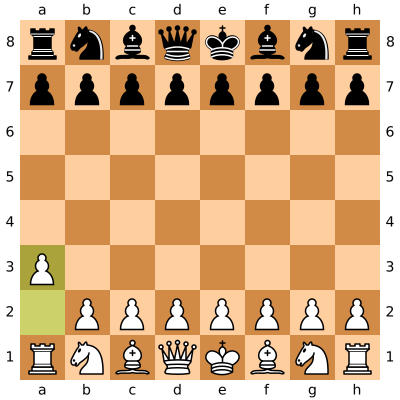

In [18]:
board = chess.Board()
board.push_san('a3')
# board.push_san(move)
board

First Step Board Initilization

In [19]:
def Move_prediction(board):
  matrix = make_matrix(board)
  trans = translate(matrix,chess_dict)


  data = np.reshape(trans, (1, 8, 8, 12))
  piece = translate_pred(model_pieces.predict(data))
  alpha = translate_pred(model_alpha.predict(data))
  number = translate_pred(model_alpha.predict(data))
  piece_pred = new_chess_dict[tuple(piece)]
  alpha_pred = new_alpha_dict[tuple(alpha)]
  number_pred = new_number_dict[tuple(number)]
  move = str(piece_pred)+str(alpha_pred)+str(number_pred)

  if move[0]=='p':
    move=move[1:]
  else:
    move= move
  return move

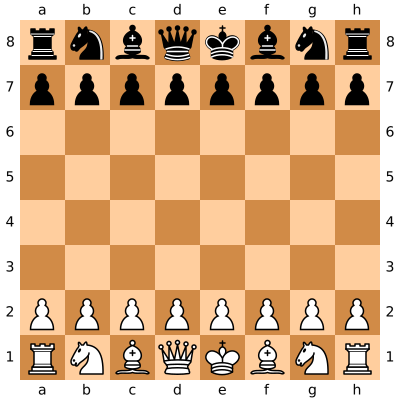

In [20]:
import random
board = chess.Board()
board

Random stage move prediction


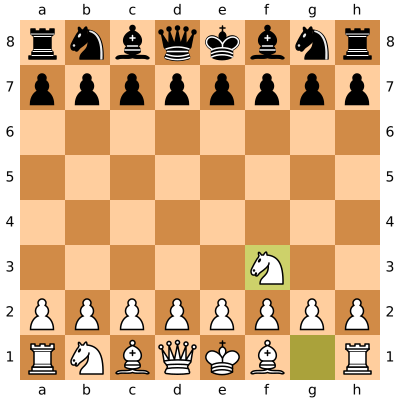

In [21]:
try:
  move=Move_prediction(board)
  board.push_san(move)
  print('Deep learning Move prediction')
except:
  All_possible_moves=list(board.legal_moves)
  Starting_move=All_possible_moves[random.randint(0,len(All_possible_moves)-1)]
  board.push(Starting_move)
  print('Random stage move prediction')
board